In [1]:
import numpy as np

import theano
import theano.tensor as T
import lasagne

from tqdm import tqdm

import time
from IPython import display

import matplotlib.pyplot as plt

import networkx as nx

In [2]:
from sklearn.mixture import GaussianMixture, GMM

# VAE

In [3]:
letter_to_num = {}
letter_to_num['A'] = 0
letter_to_num['C'] = 1
letter_to_num['T'] = 2
letter_to_num['G'] = 3

In [4]:
num_to_letter = {}
num_to_letter[0] = 'A'
num_to_letter[1] = 'C'
num_to_letter[2] = 'T'
num_to_letter[3] = 'G'

In [5]:
def arr_to_sp(arr):
    sp = []
    for x in arr.reshape((32, 4)):
        sp.append(num_to_letter[np.where(x)[0][0]])
    return ''.join(sp)

In [6]:
def get_most_often(X, clusters_all, cluster):
    mask = clusters_all == cluster
    
    X_u, counts = np.unique(X[mask], return_counts=True, axis = 0)
    
    return X_u[np.argmax(counts)]

In [7]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, n))
    #colors_res = np.zeros((n, 4))
    #for i in range(n):
    #    colors_res[i] = colors(i)
    return colors

In [8]:
def clusters_to_colors(clusters, colors):
    cluster_colors = np.zeros((clusters.shape[0], 4))

    for i in range(clusters.shape[0]):
        cluster_colors[i] = colors[clusters[i]]
    
    return cluster_colors

In [9]:
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [10]:
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams

class GaussianSampleLayer(lasagne.layers.MergeLayer):
    def __init__(self, mu, logsigma, **kwargs):
        self.rng = RandomStreams(lasagne.random.get_rng().randint(1,2147462579))
        super(GaussianSampleLayer, self).__init__([mu, logsigma], **kwargs)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, deterministic=False, **kwargs):
        mu, logsigma = inputs
        shape=(self.input_shapes[0][0] or inputs[0].shape[0],
                self.input_shapes[0][1] or inputs[0].shape[1])
        if deterministic:
            return mu
        return mu + T.exp(logsigma) * self.rng.normal(shape)

In [11]:
def KL_divergence(mu, log_sigma):
    KLD = 0.5 * T.sum(1 + 2*log_sigma - T.sqr(mu) - T.exp(2*log_sigma))
    return KLD

def log_likelihood(tgt, mu, ls):
    return T.sum(-(np.float32(0.5 * np.log(2 * np.pi)) + ls)
            - 0.5 * T.sqr(tgt - mu) / T.exp(2 * ls) )

In [12]:
def get_VAE(input_X, lr, w= 10, HU_encoder = 50, HU_decoder = 50, dimZ = 2, input_shape = [None,32*4]):
    vl_input = lasagne.layers.InputLayer(input_shape)
    vl_enc_hid = lasagne.layers.DenseLayer(vl_input, num_units=HU_encoder, nonlinearity = lasagne.nonlinearities.elu)
    vl_enc_mu = lasagne.layers.DenseLayer(vl_enc_hid, dimZ, nonlinearity = None)
    vl_enc_logsigma = lasagne.layers.DenseLayer(vl_enc_hid, num_units=dimZ, nonlinearity = None)
    vl_z = GaussianSampleLayer(vl_enc_mu, vl_enc_logsigma)
    vl_dec_hid = lasagne.layers.DenseLayer(vl_z, num_units=HU_decoder, nonlinearity = lasagne.nonlinearities.elu)
    vl_dec_mu = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                                          nonlinearity = lasagne.nonlinearities.sigmoid)
    relu_shift = 2
    vl_dec_logsigma = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                        nonlinearity = lambda a: T.nnet.relu(a+relu_shift)-relu_shift)
    vl_output = GaussianSampleLayer(vl_dec_mu, vl_dec_logsigma)
    
    print("Theano started")
    # create prediction variable
    v_prediction = lasagne.layers.get_output(vl_output, inputs = input_X, deterministic=True)
    # create loss function
    mu_z = lasagne.layers.get_output(vl_enc_mu, inputs= input_X)
    logsigma_z = lasagne.layers.get_output(vl_enc_logsigma, inputs= input_X)
    mu_x = lasagne.layers.get_output(vl_dec_mu, inputs= input_X)
    logsigma_x = lasagne.layers.get_output(vl_dec_logsigma,inputs= input_X)
    v_loss = -1*(w* KL_divergence(mu_z,logsigma_z) + log_likelihood(input_X, mu_x, logsigma_x))


    # create parameter update expressions
    v_params = lasagne.layers.get_all_params(vl_output, trainable = True)
    v_updates = lasagne.updates.adam(v_loss, v_params, learning_rate=lr)

    # compile training and testing functions
    v_train_fn = theano.function([input_X], v_loss, updates = v_updates)
    v_test_fn = theano.function([input_X], v_prediction)
    v_test_loss_fn = theano.function([input_X], v_loss)
    v_logloss_fn = theano.function([input_X], log_likelihood(input_X, mu_x, logsigma_x))

    internal = theano.function([input_X], mu_z)
    
    return v_train_fn, v_test_fn, internal

In [51]:
input_X = T.matrix("X")
input_shape = [None,32*4]

lr = theano.shared(0.001)

train_fn, test_fn, internal = get_VAE(input_X, lr)

Theano started


In [52]:
X = np.load("./data/npy/ES3_R1.npy")

In [57]:
epochs = 30
v_losses_train = []
v_logloss = []
#v_losses_valid = []
#val_batches = 500
batch_size = 100

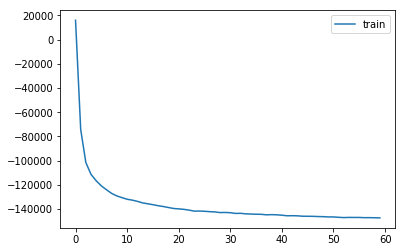

In [140]:
for epoch in range(epochs):
    ls_tr = 0.
    logloss_tr = 0.
    for batch in iterate_minibatches(X, batch_size):
        ls_tr += train_fn(batch)
        
    v_losses_train.append(ls_tr/ batch_size)
    #for batch in iterate_minibatches(X_val, val_batches):
    #    ls_val += v_test_loss_fn(batch)
    #v_losses_valid.append(ls_val/ val_batches)
    lr = lr * 0.95
    
    if epoch%2==1:
        display.clear_output(wait=True)
        plt.plot(v_losses_train, label='train')
    #    plt.plot(v_losses_valid, label='validation')
        plt.legend()
        plt.show()

In [143]:
Z = internal(X)

Z_u = np.unique(Z, axis = 0)

(1977, 2)

In [13]:
def do_network(X, epochs, w):
    input_X = T.matrix("X")
    input_shape = [None,32*4]

    lr = theano.shared(0.001)

    train_fn, test_fn, internal = get_VAE(input_X, lr, w)
    
    v_losses_train = []
    batch_size = 100
    
    for epoch in range(epochs):
        ls_tr = 0.
        logloss_tr = 0.
        for batch in iterate_minibatches(X, batch_size):
            ls_tr += train_fn(batch)

        v_losses_train.append(ls_tr/ batch_size)
        lr = lr * 0.95

        if epoch%2==1:
            display.clear_output(wait=True)
            plt.plot(v_losses_train, label='train')
            plt.legend()
            plt.show()
        
    return internal

# GMM

In [14]:
def do_gmm(Z, clusters_num = 20):
    Z_u = np.unique(Z, axis = 0)
    gmm = GaussianMixture(clusters_num, verbose = 0, n_init=10)
    gmm.fit(Z_u)

    clusters_all = gmm.predict(Z)
    colors = get_cmap(clusters_num)
    colors_all = clusters_to_colors(clusters_all, colors)
    
    fig, ax =  plt.subplots()
    fig.set_size_inches(10, 10)
    ax.scatter(Z[:, 0], Z[:,1], alpha = 1, c = colors_all)
    plt.show()
    
    return gmm, clusters_all, colors_all

Initialization 0
  Iteration 0
Initialization converged: True
Initialization 1
  Iteration 0
Initialization converged: True
Initialization 2
  Iteration 0
Initialization converged: True
Initialization 3
  Iteration 0
Initialization converged: True
Initialization 4
  Iteration 0
Initialization converged: True
Initialization 5
  Iteration 0
Initialization converged: True
Initialization 6
  Iteration 0
Initialization converged: True
Initialization 7
  Iteration 0
Initialization converged: True
Initialization 8
  Iteration 0
Initialization converged: True
Initialization 9
  Iteration 0
Initialization converged: True


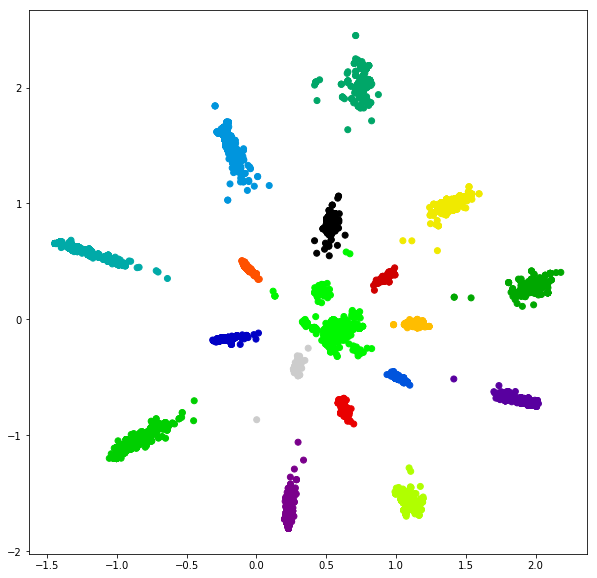

In [219]:
gmm = do_gmm(Z, 18)

In [286]:
clusters_all = gmm.predict(Z)
colors = get_cmap(clusters_num)
colors_all = clusters_to_colors(clusters_all, colors)

In [73]:
mask = clusters_all == 1

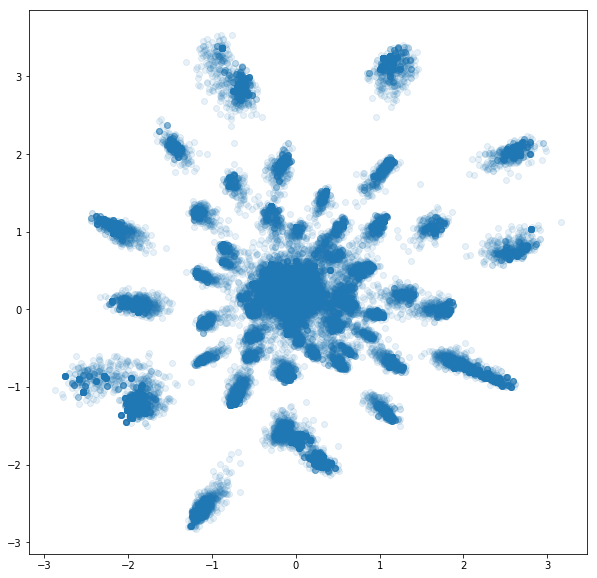

In [77]:
fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
#ax.scatter(Z[:, 0][mask], Z[:,1][mask], alpha = 1, marker='x', s =1000, c = colors_all[mask])
ax.scatter(Z[:, 0], Z[:,1], alpha = 0.1)#, c = colors_all)
plt.show()

# GRAPH

In [24]:
def to_graph(gr, clusters_num, edges_num):
    G=nx.Graph()
    G.add_nodes_from(np.arange(clusters_num))
    
    edges = []
    curr_weight = 1000
    #while curr_weight > 100:
    for i in range(edges_num):
        lin_max = np.argmax(gr)
        curr_weight = np.max(gr)
        
        x, y = lin_max // gr.shape[0], lin_max % gr.shape[0]
        gr[x][y] = 0
        gr[y][x] = 0

        G.add_edge(x, y)
        edges.append([x, y])
    
    #arr_to_sp(sp_9)
    return edges, G

In [43]:
def get_chain(X_pairs, gmm, clusters_num, links, internal):
    Z_pairs_0 = internal(X_pairs[:,0,:])
    Z_pairs_1 = internal(X_pairs[:,1,:])
    
    c_0 = gmm.predict(Z_pairs_0)
    c_1 = gmm.predict(Z_pairs_1)
    c_p = np.concatenate((c_0.reshape(-1, 1), c_1.reshape(-1, 1)), 1)
    
    graph = np.zeros((clusters_num,clusters_num)).astype(int)
    graph_ret = np.zeros((clusters_num,clusters_num)).astype(int)

    for p in tqdm(c_p):
        graph[p[0]][p[1]] += 1
        graph_ret[p[0]][p[1]] += 1
        
    pairs, G = to_graph(graph, clusters_num, links)
    
    fig, ax = plt.subplots(figsize=(20, 10))
    nx.draw_networkx(G, edge_color='b', node_size=1)
    plt.show()
    
    
    #arr_to_sp(sp_9)
    return G, c_p, pairs, graph_ret

100%|██████████| 74627/74627 [00:00<00:00, 434488.78it/s]


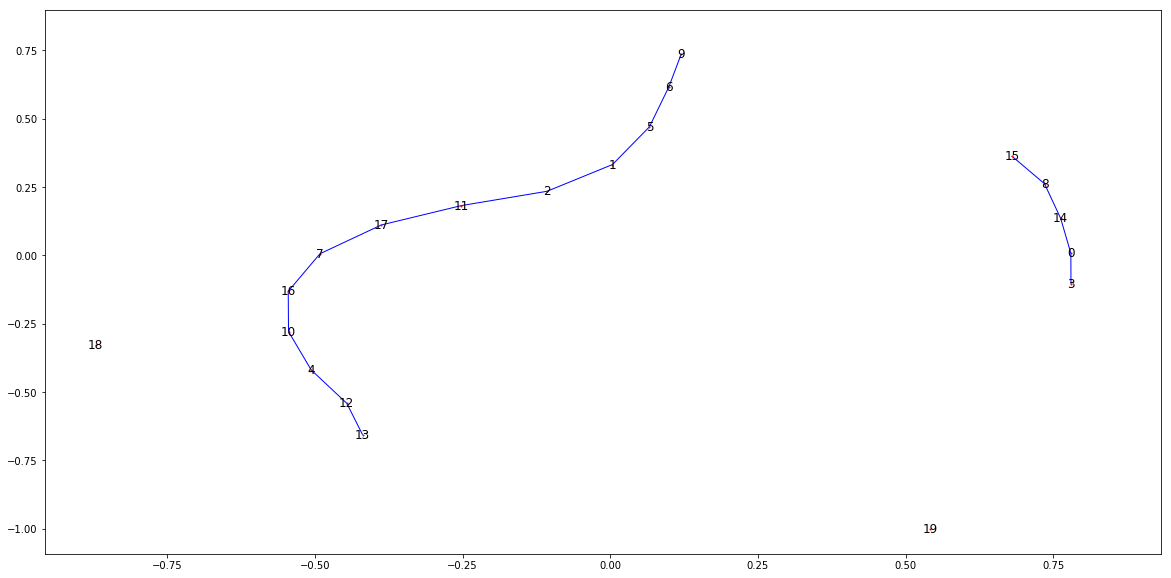

In [340]:
get_chain(X_pairs, gmm, clusters_num, clusters_num - 3)

In [345]:
c_p.shape

(74627, 2)

In [343]:
clusters_to_continue = set([10, 18, 19])

In [479]:
def filter_pairs(X, X_pairs, clusters_all, clusters_pairs, clusters_to_continue):
    x_mask = np.array([x in clusters_to_continue for x in clusters_all])
    x_pairs_mask = np.array([x[0] in clusters_to_continue and x[1] in clusters_to_continue for x in clusters_pairs])
    
    print(x_mask.sum(), x_pairs_mask.sum())
    return X[x_mask], X_pairs[x_pairs_mask]

In [354]:
X_1, X_pairs_1 = filter_pairs(X, X_pairs, clusters_all, c_p, clusters_to_continue)

7175 4600


# CYCLE

In [55]:
X = np.load("./data/npy/SlO1_R1.npy")

In [56]:
X_pairs = np.load("./data/npy/SlO_pairs.npy")

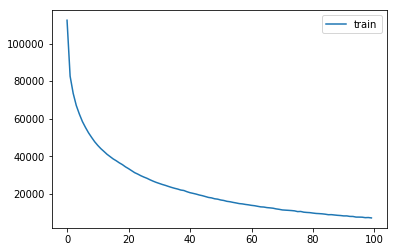

In [69]:
internal = do_network(X, 100, 5)

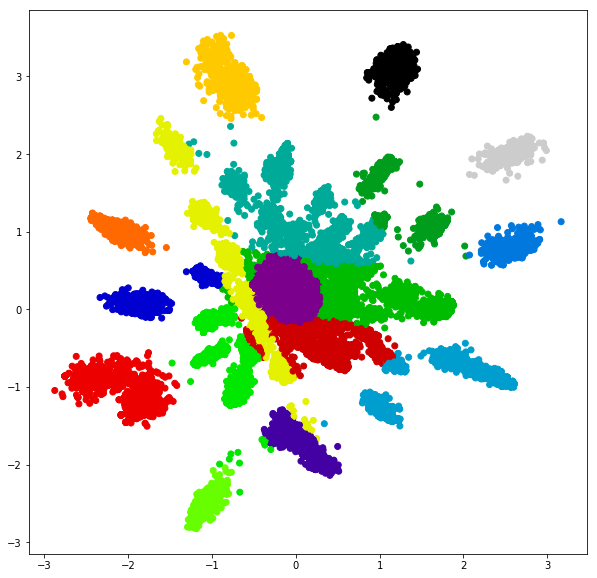

In [70]:
Z = internal(X)
clusters_num = 17
gmm, clusters_all, colors_all = do_gmm(Z, clusters_num)

100%|██████████| 54734/54734 [00:00<00:00, 379767.60it/s]


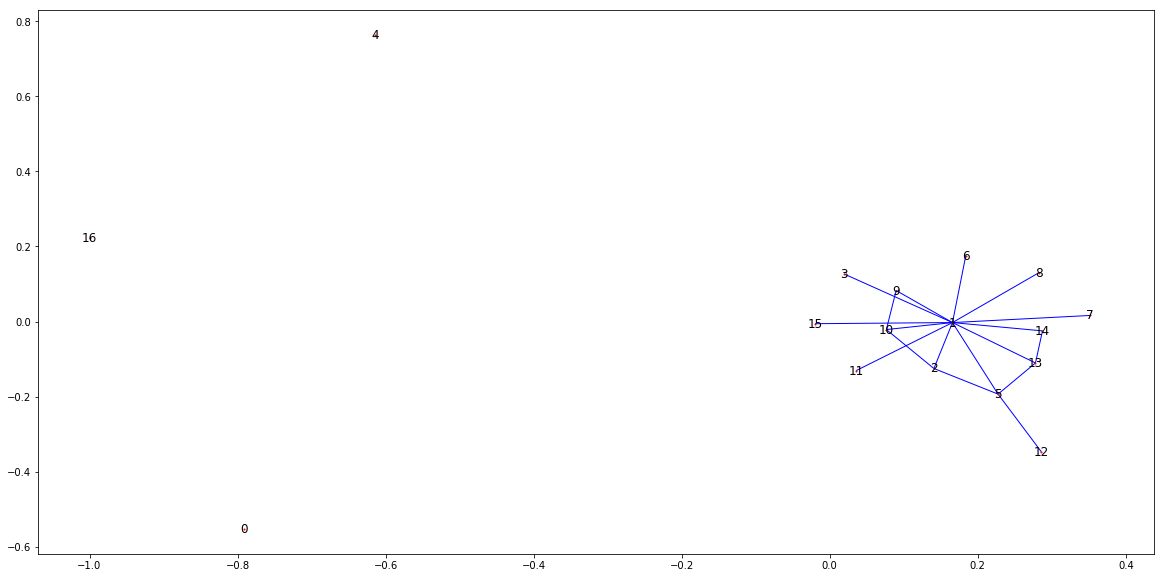

In [72]:
G, c_p, pairs, g_r = get_chain(X_pairs, gmm, clusters_num, 20, internal)

In [51]:
g_r[g_r != 0]

array([  2,   4,   1, 269, 136,   1,   2,  17,  12,   1,   2,   1,   1,
         1,   2])

In [530]:
for i in range(19):
    print(i, arr_to_sp(get_most_often(X, clusters_all,i)))

0 GTAGTCCATCATTCCACCTATGTCTGAACTCC
1 AGTGCTGGACCATTTCAAATTCACAATAGATT
2 TACCGTACAGACTGCCGGATATTATTTTTTTG
3 TATAGAGATCGTTTTTGGAATTTACAGCGAGG
4 CAAGTGATATCCATCATCGCATCCAGTGCGCC
5 GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC
6 ATAGACCCCGAACAACAATACGCGCAAACCGA
7 ACACGCCCTTATCAAATAGCTGTGATTTACCT
8 CCGTAAGTGGTTTGAGCGATGATATTTGTGCT
9 CATAAAGAAACTATTTTGCGTTTCGTTCAGGT
10 TGCATGGCTTTGGCTTCCTCTTTGACGGACGC
11 AGCTGGGCGAAATTTTGATTCATCGTGATGAC
12 CTGCTGCTCGAGCTGGTGGAGTGCTGCTATAG
13 CCCTCACACCGATTCGCCAAACGGTGGAGAAG
14 ATATATCAGAGCAAAAAACAAAGCCACAGCCA
15 GGAATGATATTTCAATAAATAATTATAACAAT
16 AACGTCAGGTTGTCGCCGCTCTGCGTGGTCGC
17 TTTTACAGTGTCAACAATCGTTCCCTGATTGT
18 CCGCCGTTGGCACCGTCAAACTCCGGTACTGT


In [ ]:
GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC

In [441]:
for ans in X_ans.items()[0][1][:]:
    z_ans = internal(ans)
    
    print(gmm.predict(z_ans))

[0 0 0 0 0 0 0 0 0 0 0 0]
[5 0 0 0 0 0]
[ 5  7  6  2 12 16 10 14  9 17 18  3  8]
[ 1 15 13 11]


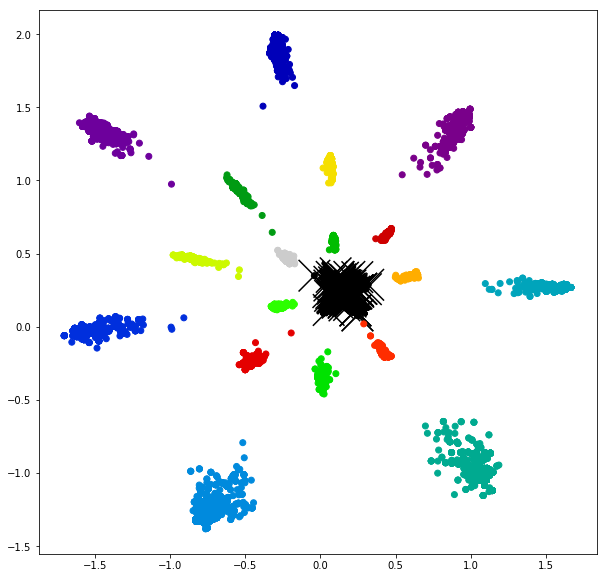

In [442]:
mask = np.logical_or(clusters_all == 0, clusters_all == 0)

fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z[:, 0][mask], Z[:,1][mask], alpha = 1, marker='x', s =1000, c = colors_all[mask])
ax.scatter(Z[:, 0], Z[:,1], alpha = 1, c = colors_all)
ax.legend()
plt.show()

In [445]:
clusters_to_continue = set([0])

In [480]:
X_second, X_pairs_secong = filter_pairs(X, X_pairs, clusters_all, c_p, clusters_to_continue)

3920 994


In [481]:
X_pairs_second =X_pairs_secong

#### 2

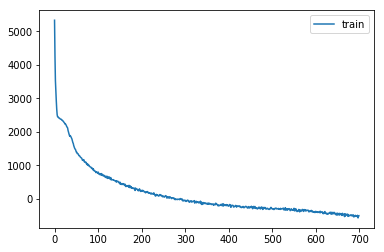

In [504]:
internal_second = do_network(X_second, 1000, 20)

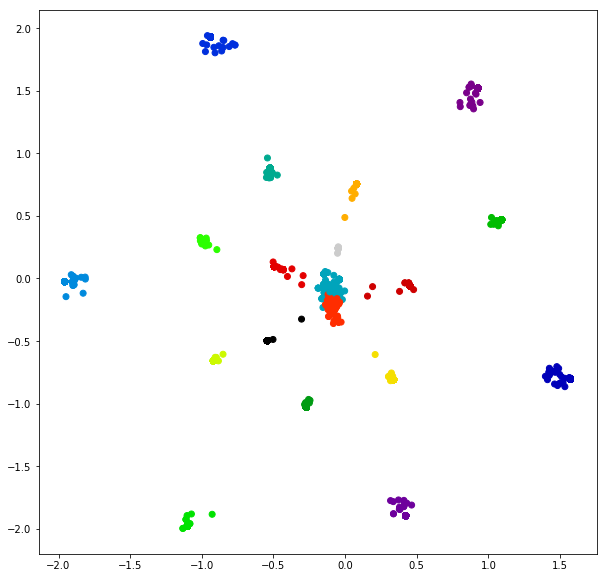

In [522]:
Z_second = internal_second(X_second)
clusters_num_second = 19
gmm_second, clusters_all_second, colors_all_second = do_gmm(Z_second, clusters_num_second)

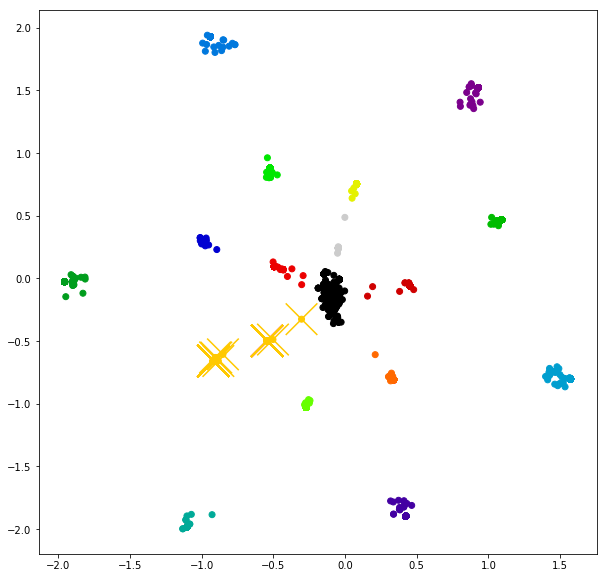

In [520]:
mask = clusters_all_second == 12

fig, ax =  plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(Z_second[:, 0][mask], Z_second[:,1][mask], alpha = 1, marker='x', s =1000, c = colors_all_second[mask])
ax.scatter(Z_second[:, 0], Z_second[:,1], alpha = 1, c = colors_all_second)
ax.legend()
plt.show()

100%|██████████| 994/994 [00:00<00:00, 302264.78it/s]


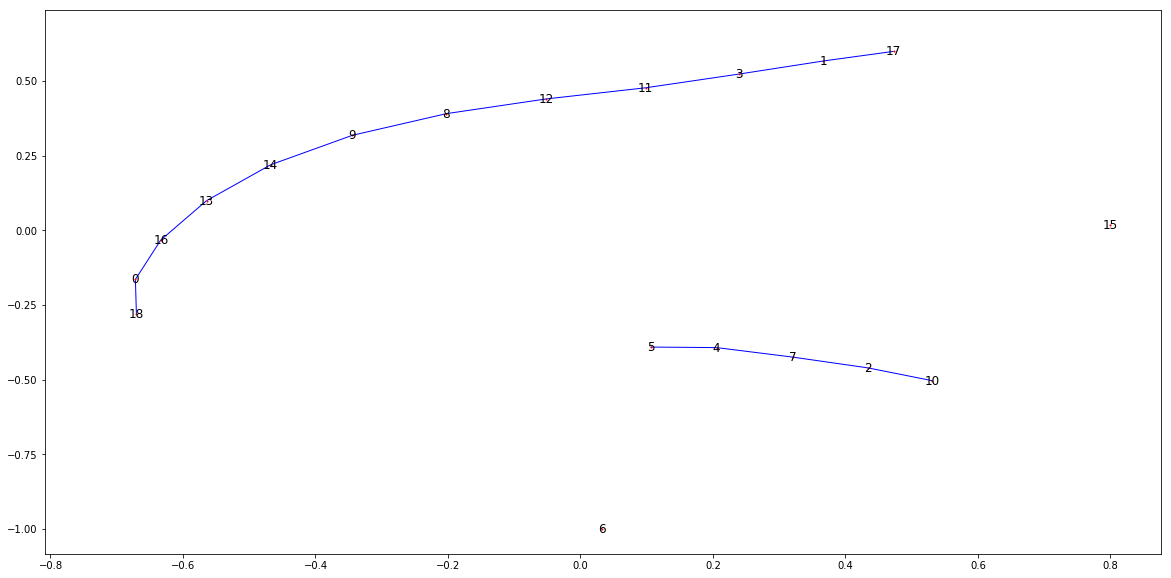

In [546]:
G_second, c_p_second, pairs_second = get_chain(X_pairs_second, gmm_second, clusters_num_second, 15, internal_second)

In [531]:
for i in range(19):
    print(i, arr_to_sp(get_most_often(X_second, clusters_all_second,i)))

0 AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG
1 TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG
2 GAAATGCTGGTGAGCGTTAATGCCGCAAACAC
3 GTAGTCCATCATTCCACCTATGTCTGAACTCC
4 GGGCGCACGGAATACAAAGCCGTGTATCTGCT
5 CTGTTTTCGCAAATCTATGGACTATTGCTATT
6 GGCAATAGCGAACAACAAGGTCGGTTGTTTGA
7 TGGCTCTGCAACAGCAGCACCCATGACCACGT
8 AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC
9 TAGTTTCCGTATCTCCGGATTTATAAAGCTGA
10 ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC
11 CCGGGGGATAATGTTTACGGTCATGCGCCCCC
12 TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG
13 GCGACCGCTCAGAAATTCCAGACCCGATCCAA
14 GCAGGCGGCGACGCGCAGGGTATGCGCGATTC
15 AAGTTCGACAACTTAAAAAATGATAACAAGTC
16 TCAACATTATCAATTACAACCGACAGGGAGCC
17 CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC
18 TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG


In [547]:
pairs_second

[[1, 3],
 [3, 11],
 [5, 4],
 [2, 10],
 [4, 7],
 [7, 2],
 [8, 9],
 [12, 8],
 [14, 13],
 [9, 14],
 [11, 12],
 [13, 16],
 [16, 0],
 [17, 1],
 [0, 18]]

In [ ]:
curr = 17 



In [524]:
for ans in X_ans.items()[0][1][:]:
    z_ans = internal_second(ans)
    
    print(gmm_second.predict(z_ans))

[17  1  3 11 12  8  9 14 13 16  0 18]
[15  5  4  7  2 10]
[15  6  6  6  6  6  0 15  6 15  6  6  6]
[15 15 15  6]


In [544]:
c_p_second

(994, 2)

In [369]:
clusters_to_continue = set([4])

In [ ]:
X

In [367]:
X_ans = np.load("./data/npy/ES3_R1_ans.npy.npz")

In [221]:
Z_pairs_0 = internal(X_pairs[:,0,:])
Z_pairs_1 = internal(X_pairs[:,1,:])

In [222]:
c_0 = gmm.predict(Z_pairs_0)
c_1 = gmm.predict(Z_pairs_1)

In [235]:
c_p = np.concatenate((c_0.reshape(-1, 1), c_1.reshape(-1, 1)), 1)

In [292]:
graph = np.zeros((clusters_num,clusters_num)).astype(int)


for p in tqdm(c_p):
    graph[p[0]][p[1]] += 1

100%|██████████| 74627/74627 [00:00<00:00, 537718.90it/s]


In [299]:
graph = np.zeros((clusters_num,clusters_num)).astype(int)

for p in tqdm(c_p):
    graph[p[0]][p[1]] += 1
    
def to_graph(gr, clusters_num, edges_num):
    G=nx.Graph()
    G.add_nodes_from(np.arange(clusters_num))
    
    edges = []
    curr_weight = 1000
    #while curr_weight > 100:
    for i in range(edges_num):
        lin_max = np.argmax(gr)
        curr_weight = np.max(gr)
        
        x, y = lin_max // gr.shape[0], lin_max % gr.shape[0]
        gr[x][y] = 0
        gr[y][x] = 0

        G.add_edge(x, y)
        edges.append([x, y])
    
    #arr_to_sp(sp_9)
    return edges, G

100%|██████████| 74627/74627 [00:00<00:00, 549835.80it/s]


In [300]:
pairs, G = to_graph(graph, clusters_num, clusters_num - 3)

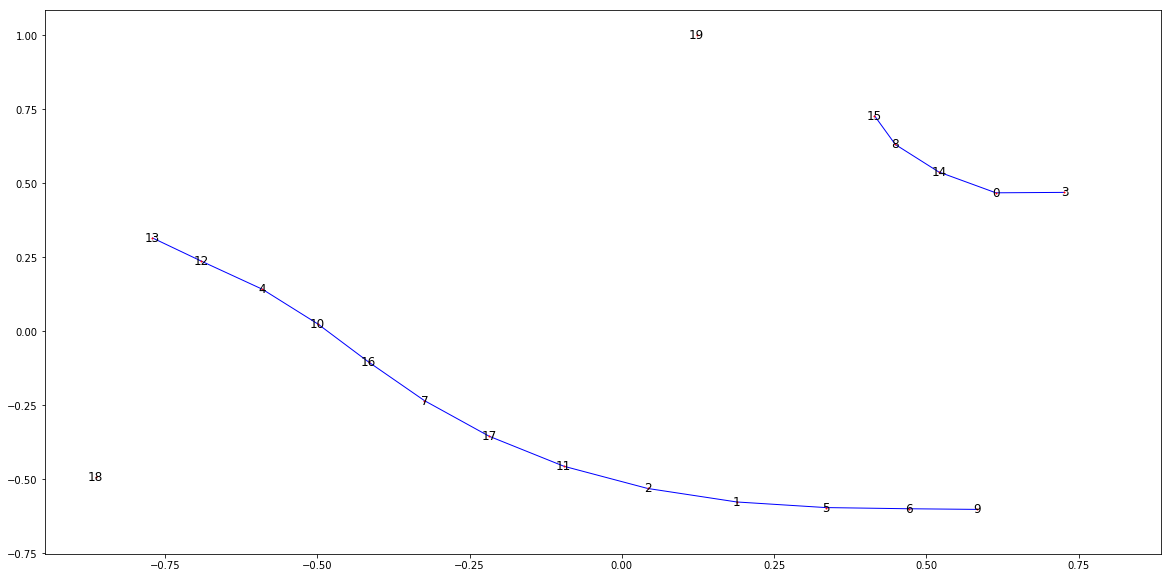

In [301]:
fig, ax = plt.subplots(figsize=(20, 10))
nx.draw_networkx(G, edge_color='b', node_size=1)
#nx.draw_networkx(G_ans, edge_color='r', node_size=1)
#nx.draw_networkx_edges(G, )
plt.show()

In [332]:
for i in range(20):
    print(Z[clusters_all == i].mean(0))

[ 0.53586948  0.89521305]
[ 0.22133572 -1.74805519]
[ 1.95108428 -0.72391282]
[-0.26362163 -0.17267777]
[ 1.044468   -0.52015537]
[-0.22827305  1.62247082]
[-1.34880272  0.62960182]
[ 0.74738359  2.17262867]
[ 2.06445872  0.29566447]
[-0.95013428 -1.11908301]
[ 0.51676725  0.05715029]
[ 1.13286483 -1.65287157]
[ 1.46405781  1.05730151]
[ 1.16169403 -0.03542063]
[-0.07802807  0.45373693]
[ 0.63485398 -0.82409468]
[ 0.94857281  0.38557083]
[ 0.2779853  -0.42797587]
[ nan  nan]
[ nan  nan]


/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  


In [332]:
for i in range(20):
    print(Z[clusters_all == i].mean(0))

[ 0.53586948  0.89521305]
[ 0.22133572 -1.74805519]
[ 1.95108428 -0.72391282]
[-0.26362163 -0.17267777]
[ 1.044468   -0.52015537]
[-0.22827305  1.62247082]
[-1.34880272  0.62960182]
[ 0.74738359  2.17262867]
[ 2.06445872  0.29566447]
[-0.95013428 -1.11908301]
[ 0.51676725  0.05715029]
[ 1.13286483 -1.65287157]
[ 1.46405781  1.05730151]
[ 1.16169403 -0.03542063]
[-0.07802807  0.45373693]
[ 0.63485398 -0.82409468]
[ 0.94857281  0.38557083]
[ 0.2779853  -0.42797587]
[ nan  nan]
[ nan  nan]


/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  


In [332]:
for i in range(20):
    print(Z[clusters_all == i].mean(0))

[ 0.53586948  0.89521305]
[ 0.22133572 -1.74805519]
[ 1.95108428 -0.72391282]
[-0.26362163 -0.17267777]
[ 1.044468   -0.52015537]
[-0.22827305  1.62247082]
[-1.34880272  0.62960182]
[ 0.74738359  2.17262867]
[ 2.06445872  0.29566447]
[-0.95013428 -1.11908301]
[ 0.51676725  0.05715029]
[ 1.13286483 -1.65287157]
[ 1.46405781  1.05730151]
[ 1.16169403 -0.03542063]
[-0.07802807  0.45373693]
[ 0.63485398 -0.82409468]
[ 0.94857281  0.38557083]
[ 0.2779853  -0.42797587]
[ nan  nan]
[ nan  nan]


/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  


In [ ]:
def get_central_cluster_num(Z, clusters_all):
    

In [333]:
Z.mean(0)

array([-0.01019364, -0.00608249])

In [314]:
for get_most_often(X, clusters_all, 9)

In [316]:
arr_to_sp(sp_9)

'GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC'

In [311]:
np.where(np.array([0,0,1,0]))[0][0]

2

In [230]:
lists = []

for pair in pairs[:30]:
    if len(lists) == 0:
        lists.append([pair[0], pair[1]])
    else:
        put = True
        for l in lists:
            if l[0] == pair[1]:
                l = [pair[0]] + l
                put = False
            if l[-1] == pair[0]:
                l.append(pair[1])
                put = False
        if put:
            lists.append([pair[0], pair[1]])
                




False [6, 5]
True [3, 0]
False [0, 14]
False [5, 1]
True [8, 15]
False [1, 2]
False [14, 8]
False [2, 11]
True [12, 13]
False [11, 17]
True [16, 10]
False [17, 7]
False [7, 16]
False [10, 10]
False [4, 12]
False [10, 4]
True [9, 10]
True [3, 10]
False [3, 9]
True [3, 6]
True [3, 15]
True [3, 2]
True [9, 2]
True [3, 5]
True [9, 11]
False [9, 8]
True [9, 15]
False [3, 12]
True [9, 13]


In [231]:
lists[:10]

[[9, 6, 5, 1, 2, 11, 17, 7, 16],
 [3, 0, 14, 8],
 [8, 15],
 [12, 13],
 [16, 10, 10, 4],
 [9, 10],
 [3, 10],
 [3, 6],
 [3, 15],
 [3, 2]]

In [132]:
z_ans

array([[-1.14949492, -1.1740142 ],
       [-1.30101832,  0.49389038],
       [-0.31274551,  1.69436592],
       [ 0.15424339, -1.73956254],
       [ 1.89439947, -0.74905676],
       [ 1.10844758, -1.70679704],
       [ 0.21716161, -0.43328585],
       [ 0.81502299,  2.15595959],
       [ 0.89742379,  0.34754733],
       [ 0.40866929,  0.23310013],
       [ 0.96499633, -0.49965226],
       [ 1.38951821,  0.98150506],
       [ 1.11682024, -0.08184951]])

In [234]:
def do_all(X, X_pairs, clusters_num):
    input_X = T.matrix("X")
    input_shape = [None,32*4]
    lr = theano.shared(0.001)

    train_fn, test_fn, internal = get_VAE(input_X, lr)
    
    epochs = 30
    v_losses_train = []
    batch_size = 100
    
    for epoch in range(epochs):
        ls_tr = 0.
        logloss_tr = 0.
        for batch in iterate_minibatches(X, batch_size):
            ls_tr += train_fn(batch)

        v_losses_train.append(ls_tr/ batch_size)
        lr = lr * 0.95

        if epoch%2==1:
            display.clear_output(wait=True)
            plt.plot(v_losses_train, label='train')
            plt.legend()
            plt.show()
            
    Z = internal(X)
    
    gmm = do_gmm(Z, clusters_num)
    
    

In [82]:
with open("./data/ES/ES1_R1_pairs.txt") as f:
    lines = f.readlines()
    
lines = [x[:-2] for x in lines]
pairs = [x.split(" ") for x in lines]

In [83]:
es_3 = []

for a, b in pairs:
    es_3.append(a)
    es_3.append(b)

In [84]:
es_3 = [x[:32] for x in es_3]

In [90]:
X_es_3 = to_array(es_3)

159654it [00:02, 60994.18it/s]


In [468]:
ans_es_3_1 = "CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG \
GTAGTCCATCATTCCACCTATGTCTGAACTCC CCGGGGGATAATGTTTACGGTCATGCGCCCCC TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG \
AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC TAGTTTCCGTATCTCCGGATTTATAAAGCTGA GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG \
GCGACCGCTCAGAAATTCCAGACCCGATCCAAA TCAACATTATCAATTACAACCGACAGGGAGCC AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG \
TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG "
ans_es_3_2 = "GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC CTGTTTTCGCAAATCTATGGACTATTGCTATT \
GGGCGCACGGAATACAAAGCCGTGTATCTGCT TGGCTCTGCAACAGCAGCACCCATGACCACGT GAAATGCTGGTGAGCGTTAATGCCGCAAACAC \
ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC "
ans_es_3_3 = "GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC ACACGCCCTTATCAAATAGCTGTGATTTACCTA \
ATAGACCCCGAACAACAATACGCGCAAACCGA TACCGTACAGACTGCCGGATATTATTTTTTTG CTGCTGCTCGAGCTGGTGGAGTGCTGCTATAG \
AACGTCAGGTTGTCGCCGCTCTGCGTGGTCGC TGCATGGCTTTGGCTTCCTCTTTGACGGACGC ATATATCAGAGCAAAAAACAAAGCCACAGCCA \
CATAAAGAAACTATTTTGCGTTTCGTTCAGGT TTTTACAGTGTCAACAATCGTTCCCTGATTGT CCGCCGTTGGCACCGTCAAACTCCGGTACTGT \
TATAGAGATCGTTTTTGGAATTTACAGCGAGG CCGTAAGTGGTTTGAGCGATGATATTTGTGCT "
ans_es_3_4 = "AGTGCTGGACCATTTCAAATTCACAATAGATT GGAATGATATTTCAATAAATAATTATAACAAT \
CCCTCACACCGATTCGCCAAACGGTGGAGAAG AGCTGGGCGAAATTTTGATTCATCGTGATGAC "

In [471]:
for a in ans_es_3_1.split() + ans_es_3_2.split():
    if a in ans_es_3_3.split() or a in  ans_es_3_4.split():
        print(a)

GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC


In [323]:
ans_es_3 = [x[:32] for x in (ans_es_3_1 + " " + ans_es_3_2 + " " + ans_es_3_3 + " " + ans_es_3_4).split()]

In [324]:
X_ans_es_3 = to_array(ans_es_3)

35it [00:00, 27594.11it/s]


In [15]:
unique = set(K_1 + K_2)

In [9]:
kept_len = 32

In [10]:
K_1 = ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC', 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG', 
       'GTAGTCCATCATTCCACCTATGTCTGAACTCC', 'CCGGGGGATAATGTTTACGGTCATGCGCCCCC', 
       'TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG', 'AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC',
       'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA', 'GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG', 
       'GCGACCGCTCAGAAATTCCAGACCCGATCCAAA','TCAACATTATCAATTACAACCGACAGGGAGCC', 
       'AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG', 'TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG']
       
K_2 = ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', 'CTGTTTTCGCAAATCTATGGACTATTGCTATT', 
       'GGGCGCACGGAATACAAAGCCGTGTATCTGCT', 'TGGCTCTGCAACAGCAGCACCCATGACCACGT', 
       'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC', 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC']

In [89]:
letter_to_num = {}
letter_to_num['A'] = 0
letter_to_num['C'] = 1
letter_to_num['T'] = 2
letter_to_num['G'] = 3

In [86]:
def process_spacer(spacer):
    ans = np.zeros(32*4)
    
    for i, letter in enumerate(spacer):
        if letter in letter_to_num.keys():
            ans[i*4 + letter_to_num[letter]] = 1
    return ans
    

In [13]:
def add_noize(spacer, prob = 0.99):
    noized = []
    for letter in spacer: 
        if np.random.random() > prob:
            noized.append(np.random.choice(["A","C","G","T", ""]))
        else:
            noized.append(letter)
    return ''.join(noized)

In [14]:
noised_data = []
K = K_1 + K_2
for i in tqdm(range(len(pairs) * 2)):
    noised_data.append(add_noize(np.random.choice(K), 0.97))
    

100%|██████████| 159654/159654 [00:08<00:00, 19507.01it/s]


In [17]:
counter = 0
for p in noised_data:
    if p in unique:
        counter += 1
counter

73362

In [18]:
noised_data = [x[:32] for x in noised_data]

In [87]:
def to_array(spacers):
    X = np.zeros((len(spacers), 32 * 4))

    for i, spacer in tqdm(enumerate(spacers)):
        X[i,:] = process_spacer(spacer)
    return X

In [19]:
X_noised = np.zeros((len(noised_data), 32 * 4))

for i, noised_spacer in tqdm(enumerate(noised_data)):
    X_noised[i,:] = process_spacer(noised_spacer)

159654it [00:02, 66800.41it/s]


In [20]:
X = np.zeros((len(K), 32 * 4))

for i, spacer in tqdm(enumerate([x[:32] for x in K])):
    X[i,:] = process_spacer(spacer)

18it [00:00, 24051.44it/s]


# ALL DATA

In [220]:
with open("./data/CRISPR_db_2109.txt") as f:
    db_lines = f.readlines()

In [221]:
db = [[y for y in x.split("\t")[1:-1] if len(y) > 0] for x in db_lines]

In [250]:
np.where(np.array([len(x) for x in db]) == 1)[0]

array([  21,   27,   39,   49,   56,   61,   67,   81,   86,   92,   98,
        118,  135,  161,  162,  170,  181,  237,  257,  312,  351,  365,
        404,  414,  419,  420,  424,  438,  445,  454,  458,  483,  504,
        506,  507,  509,  519,  559,  589,  604,  615,  633,  648,  661,
        674,  681,  687,  710,  755,  766,  783,  788,  789,  790,  827,
        862,  864,  897,  907,  965,  970,  976,  990, 1000, 1014, 1017,
       1025, 1049, 1052, 1074, 1075, 1093, 1154, 1161, 1192, 1208, 1213,
       1217, 1224, 1241, 1244, 1252, 1278, 1310, 1319, 1329, 1331, 1336,
       1342, 1354, 1361, 1374, 1383, 1425, 1434, 1440, 1505, 1506, 1553,
       1568, 1592, 1603, 1605, 1613, 1621, 1645, 1657, 1663, 1700, 1736,
       1737, 1751, 1755, 1795, 2024, 2300, 2345, 2463, 2502, 2503, 2504,
       2506, 2507, 2508, 2509, 2510, 2511, 2512, 2513, 2514, 2515, 2516,
       2517, 2518, 2519, 2520, 2521, 2522, 2523, 2525, 2526, 2527, 2528,
       2529, 2530, 2531, 2532, 2533, 2534, 2535, 25

In [252]:
np.array(db_lines)[np.where(np.array([len(x) for x in db]) == 1)[0]]

array([ '@gi|675818951:288728-289015_E_coli_FHI102_scaffold-28_contig-1.2_582909_1011299\tCTGAAACCAGTTGGCTCGTTGTTCTTCTTTGG\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|CP008805.1|:3680245-3680533_E_coli_O157:H7_str._SS17\tCTCGACTTTAATTTTTTCGCTGCCCGCTTTTG\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|KC765388.1|:1-219_E_coli_strain_96-0611_CRISPR2a\tAAGTTCGACAACTTAAAAAATGATAACAAGTC\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|KF522834.1|:288-576_E_coli_strain_H56909_CRISPR2\tCTCGACTTTAATTTTTTCGCTGCCCGCTTTTG\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|KF522734.1|:1-189_E_coli_strain_TW14359_CRISPR2\tCTCGACTTTAATTTTTTCGCTGCCCGCTTTTG\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n',
       '@gb|KF522859.1|:266-494_E_coli_strain_95.3322_CRISPR2\tATATCCGGTTTTTGCTGGTGGGCCGCGCCGT

In [260]:
all_spacers = set()

for chain in tqdm(db):
    for spacer in chain:
        all_spacers.add(spacer)

100%|██████████| 3058/3058 [00:00<00:00, 461722.22it/s]


In [261]:
all_spacers_list = [x[:32] for x in list(all_spacers) if len(x) < 40]

In [265]:
X_db = np.zeros((len(all_spacers_list), 32 * 4))

for i, spacer in tqdm(enumerate(all_spacers_list)):
    X_db[i,:] = process_spacer(spacer)

1748it [00:00, 49390.29it/s]


In [35]:
from sklearn.metrics import log_loss

In [199]:
log_loss(X[:1], v_test_fn(X[:1])) 

387.92068499768482

In [150]:
np.savez("./VAE_weights/97_noize_70_hid_10_ES1", *lasagne.layers.get_all_param_values(vl_output))

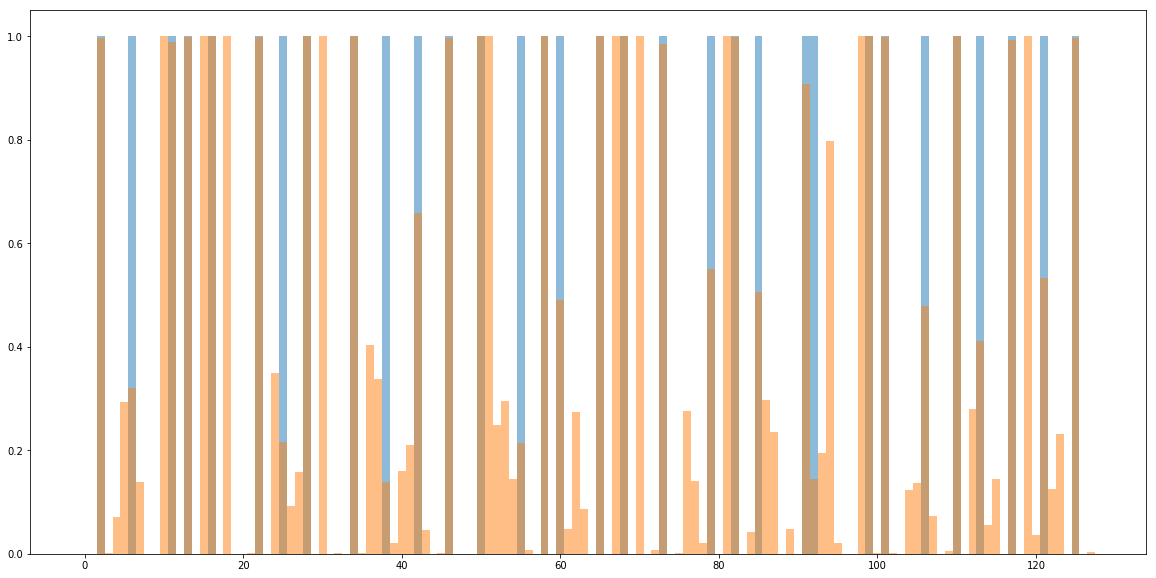

In [282]:

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
ax.bar(np.arange(32 * 4), X_db[1:2][0][:], width = 1, alpha = 0.5)
ax.bar(np.arange(32 * 4), v_test_fn(X_db[1:2])[0][:], width = 1, alpha = 0.5)
plt.show()

## Get inside 

In [106]:
Z = internal(X_es_3)

In [325]:
Z_es_3 = internal(X_es_3)
Z_ans_es_3 = internal(X_ans_es_3)

In [286]:
Z_noized = internal(X_noised)
Z = internal(X)

на уникальных

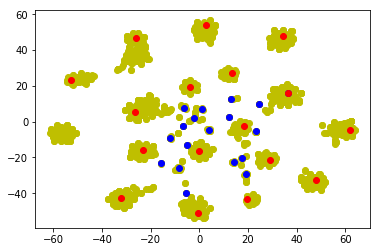

In [334]:
plt.scatter(t_noized[:, 0], t_noized[:,1], c = 'y')
plt.scatter(t_ans[:18, 0], t_ans[:18,1], c= 'b')
plt.scatter(t_ans[18:, 0], t_ans[18:,1], c = 'r')
plt.show()

In [346]:
mask = np.logical_and(t_noized[:, 0] > 0, t_noized[:, 1] < -20)

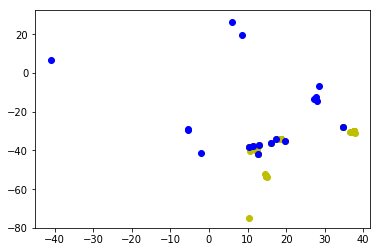

In [348]:
plt.scatter(t_noized[:, 0][mask], t_noized[:,1][mask], c = 'y')
plt.scatter(t_ans[:18, 0], t_ans[:18,1], c= 'b')
#plt.scatter(t_ans[18:, 0], t_ans[18:,1], c = 'r')
plt.show()

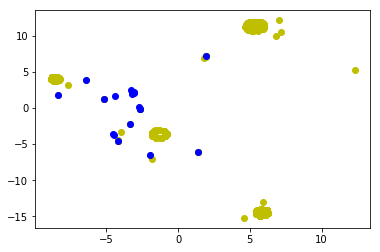

In [354]:
plt.scatter(t_noized_1[:, 0], t_noized_1[:,1], c = 'y')
plt.scatter(t_ans_1[:18, 0], t_ans_1[:18,1], c= 'b')
#plt.scatter(t_ans[18:, 0], t_ans[18:,1], c = 'r')
plt.show()

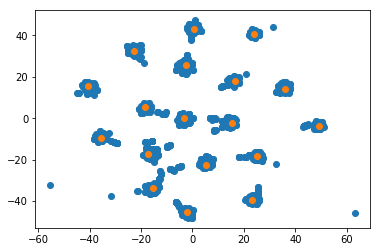

In [295]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1])
plt.show()

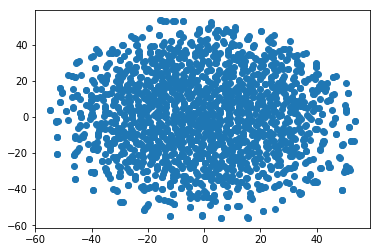

In [292]:
plt.scatter(t_db[:, 0], t_db[:,1])
#plt.scatter(Z[:, 0]  , Z[:,1])
plt.show()

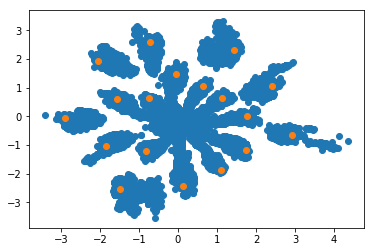

In [205]:
plt.scatter(Z_noized[:, 0], Z_noized[:,1])
plt.scatter(Z[:, 0]  , Z[:,1])
plt.show()

each 200

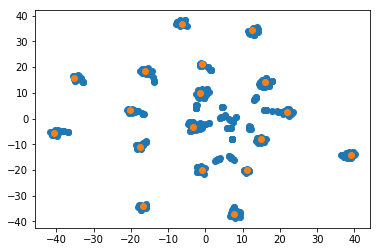

In [147]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1])
plt.show()

each 50

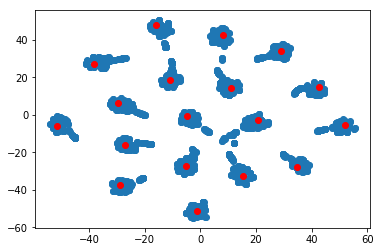

In [145]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1], c = 'R')
plt.show()

each 20

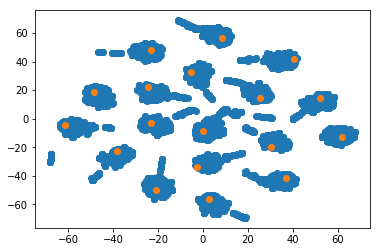

In [149]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1])
plt.show()

each 10

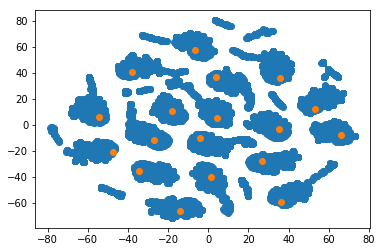

In [152]:
plt.scatter(t_noized[:, 0], t_noized[:,1])
plt.scatter(t_ans[:, 0]  , t_ans[:,1])
plt.show()

In [124]:
from sklearn.cluster import SpectralClustering

In [125]:
S_C = SpectralClustering(14)

In [129]:
clusters = S_C.fit_predict(Z_noized[::10])

MemoryError: 

In [108]:
from sklearn.manifold import TSNE

In [307]:
tsne = TSNE(2, verbose=1)

In [114]:
Z_noized_unique = np.unique(Z_noized, axis = 0)

In [115]:
Z_noized.shape

(159654, 10)

In [116]:
Z_noized_unique.shape

(28362, 10)

In [140]:
t_noized.shape

(3194, 2)

In [141]:
t_ans.shape

(3194, 2)

In [314]:
Z_es_3_u = np.unique(Z_es_3,  axis = 0)

In [315]:
t_es_3 = tsne.fit_transform(Z_es_3_u)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2123 samples in 0.006s...
[t-SNE] Computed neighbors for 2123 samples in 0.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2123
[t-SNE] Computed conditional probabilities for sample 2000 / 2123
[t-SNE] Computed conditional probabilities for sample 2123 / 2123
[t-SNE] Mean sigma: 0.480638
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.015522
[t-SNE] Error after 1000 iterations: 0.430352


In [142]:
def tsne_with_asn(tsne, data, ans):
    print(np.concatenate((data, ans)).shape)
    tsne_data = tsne.fit_transform(np.concatenate((data, ans)))
    return tsne_data[:data.shape[0]], tsne_data[-ans.shape[0]:]

In [350]:
t_noized_1, t_ans_1 = tsne_with_asn(tsne, Z_es_3[::50][mask], Z_ans_es_3[:18])

(265, 20)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 265 samples in 0.000s...
[t-SNE] Computed neighbors for 265 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 265 / 265
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.672237
[t-SNE] Error after 1000 iterations: 0.359428


### Check how much unchanged

In [18]:
len(pairs)

79827

In [69]:
counter = 0
for p in np.array(pairs).flatten():
    if p in unique:
        counter += 1

In [80]:
counter = 0
for p in noised_data:
    if p in unique:
        counter += 1

In [81]:
counter

73276

In [35]:
np.array(pairs).flatten()

array(['GGGCGCACGGAATACAAAGCCGTGTATCTGCT',
       'TGGCTCTGCAACAGCAGCACCCATGACCACG',
       'GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', ...,
       'CTGTTTTCGCAAATCTATGGACTATTGCTAT',
       'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA',
       'GCAGGCGGCGACGCGCAGGGTATGCGCGATTC'],
      dtype='<U56')

In [36]:
unique

{'AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC',
 'AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG',
 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC',
 'CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC',
 'CCGGGGGATAATGTTTACGGTCATGCGCCCCC',
 'CTGTTTTCGCAAATCTATGGACTATTGCTATT',
 'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC',
 'GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC',
 'GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG',
 'GCGACCGCTCAGAAATTCCAGACCCGATCCAAA',
 'GGGCGCACGGAATACAAAGCCGTGTATCTGCT',
 'GTAGTCCATCATTCCACCTATGTCTGAACTCC',
 'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA',
 'TCAACATTATCAATTACAACCGACAGGGAGCC',
 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG',
 'TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG',
 'TGGCTCTGCAACAGCAGCACCCATGACCACGT',
 'TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG'}

In [38]:
ans = "CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC	TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG	GTAGTCCATCATTCCACCTATGTCTGAACTCC	CCGGGGGATAATGTTTACGGTCATGCGCCCCC	TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG	AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC	TAGTTTCCGTATCTCCGGATTTATAAAGCTGA	GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG	GCGACCGCTCAGAAATTCCAGACCCGATCCAAA	TCAACATTATCAATTACAACCGACAGGGAGCC	AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG	TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG"

In [40]:
ans.split("\t") == K_1

True

# Convolutional VAE

In [186]:
input_X = T.matrix("X")
input_shape = [None, 32*4]

In [187]:
HU_encoder = 50
dimZ = 2
HU_decoder = 50

In [188]:
vl_input = lasagne.layers.InputLayer(input_shape)

vl_reshape = lasagne.layers.ReshapeLayer(vl_input, (-1, 1, 32*4))

vl_conv = lasagne.layers.Conv1DLayer(vl_reshape, 10, 8)

In [189]:
vl_flatten = lasagne.layers.flatten(vl_conv)

In [190]:
vl_enc_hid = lasagne.layers.DenseLayer(vl_flatten, num_units=HU_encoder, nonlinearity = lasagne.nonlinearities.elu)

vl_enc_mu = lasagne.layers.DenseLayer(vl_enc_hid, dimZ, nonlinearity = None)
vl_enc_logsigma = lasagne.layers.DenseLayer(vl_enc_hid, num_units=dimZ, nonlinearity = None)

vl_z = GaussianSampleLayer(vl_enc_mu, vl_enc_logsigma)

In [191]:
vl_dec_hid = lasagne.layers.DenseLayer(vl_z, num_units=HU_decoder, nonlinearity = lasagne.nonlinearities.elu)
vl_dec_mu = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                                      nonlinearity = lasagne.nonlinearities.sigmoid)
relu_shift = 2
vl_dec_logsigma = lasagne.layers.DenseLayer(vl_dec_hid, num_units=input_shape[1],
                    nonlinearity = lambda a: T.nnet.relu(a+relu_shift)-relu_shift)
vl_output = GaussianSampleLayer(vl_dec_mu, vl_dec_logsigma)

# странные дела

In [208]:
unique = dict()

for line in lines:
    if line in unique:
        unique[line] += 1
    else:
        unique[line] = 1


In [227]:
keys = []
values = []

In [225]:
unique.iteritems()

AttributeError: 'dict' object has no attribute 'iteritems'

In [228]:
for k, v in unique.items():
    keys.append(k)
    values.append(v)

In [232]:
order = np.argsort(values)[::-1]

In [248]:
np.array(keys)[order][:30]

array(['GACAGAACGGCCTCAGTAGTCTCGTCAGGCT',
       'ACACGCCCTTATCAAATAGCTGTGATTTACCT',
       'CAAGTGATATCCATCATCGCATCCAGTGCGC',
       'ATAGACCCCGAACAACAATACGCGCAAACCG',
       'AGTGCTGGACCATTTCAAATTCACAATAGAT',
       'TACCGTACAGACTGCCGGATATTATTTTTTT',
       'GGAATGATATTTCAATAAATAATTATAACAA',
       'CTGCTGCTCGAGCTGGTGGAGTGCTGCTATA',
       'TATAGAGATCGTTTTTGGAATTTACAGCGAG',
       'CCCTCACACCGATTCGCCAAACGGTGGAGAA',
       'AACGTCAGGTTGTCGCCGCTCTGCGTGGTCG',
       'AGCTGGGCGAAATTTTGATTCATCGTGATGA',
       'CCGTAAGTGGTTTGAGCGATGATATTTGTGC',
       'TGCATGGCTTTGGCTTCCTCTTTGACGGACG',
       'ATATATCAGAGCAAAAAACAAAGCCACAGCC',
       'CATAAAGAAACTATTTTGCGTTTCGTTCAGG',
       'TTTTACAGTGTCAACAATCGTTCCCTGATTG',
       'CCGCCGTTGGCACCGTCAAACTCCGGTACTG',
       'GTAGTCCATCATTCCACCTATGTCTGAACTC',
       'TCGGTTCAGGCGTTGCAAACCTGGCTACCGG',
       'CTGTTTTCGCAAATCTATGGACTATTGCTAT',
       'GGGCGCACGGAATACAAAGCCGTGTATCTGC',
       'CAGCGTCAGGCGTGAAATCTCACCGTCGTTG',
       'GAAATGCTGGTGAGCGTTAATGCCG

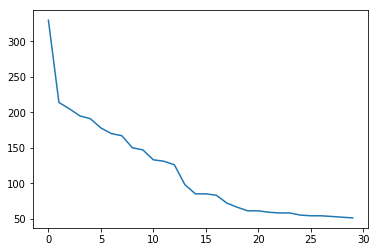

In [253]:
plt.plot(np.array(values)[order][20:50])
plt.show()

In [236]:
clusters = dict()
for i, sp in enumerate(np.array(keys)[order]):
    clusters[sp] = i

In [240]:
with open("./data/ES/ES3_R1_pairs.txt") as f:
    lines = [[y[:32] for y in x[:-2].split(' ')] for x in f.readlines()]

In [245]:
graph = np.zeros((30,30)).astype(int)


for l in tqdm(lines):
    #print(i,j)
    #graph[kmeans.predict(pair[0].reshape(1,-1)), kmeans.predict(pair[1].reshape(1,-1))] += 1
    if l[0] in clusters and  l[1] in clusters:
        if clusters[l[0]] < 30 and clusters[l[1]] < 30:
            graph[clusters[l[0]]][clusters[l[1]]] += 1

100%|██████████| 74627/74627 [00:00<00:00, 847092.56it/s]


In [206]:
with open("./data/ES/ES3_R1_spacers.txt") as f:
    lines = [x[:-2][:32] for x in f.readlines()[1:]]

In [207]:
lines

['GACAGAACGGCCTCAGTAGTCTCGTCAGGCT',
 'ACACGCCCTTATCAAATAGCTGTGATTTACCT',
 'AGTGCTGGACCATTTCAAATTCACAATAGAT',
 'GACAGAACGGCCTCAGTAGTCTCGTCAGGCT',
 'ACACGCCCTTATCAAATAGCTGTGATTTACCT',
 'ACACGCCCTTATCAAATAGCTGTGATTTACCT',
 'GACAGAACGGCCTCAGTAGTCTCGTCAGGCT',
 'GACAGAACGGCCTCAGTAGTCTCGTCAGGCT',
 'TGCCGTACAGACTGCCGGATATTATTTTTTT',
 'CTGCTGCTCGAGCTGGTGGAGTGCTGCTATA',
 'ACACGCCCTTATCAAATAGCTGTGATTTACCT',
 'TATAGAGATCGTTTTTGGAATTTACAGCGAG',
 'CCGTAAGTGGTTTGAGCGATGATATTTGTGC',
 'TATAGAGATCGTTTTTGGAATTTACAGCGAG',
 'TATAGAGATCGTTTTTGGAATTTACAGCGAG',
 'GGAATGATATTTCAATAAATAATTATAACAA',
 'CAAGTGATATCCATCATCGCATCCAGTGCGC',
 'AGTGCTGGACCATTTCAAATTCACAATAGAT',
 'ATATATCAGAGCAAAAAACAAAGCCACAGCC',
 'ACACGCCCTTATCAAATAGCTGTGATTTACCT',
 'CCCTCACACCGATTCGCCAAACGGTGGAGAA',
 'AGCTGGGCGAAATTTTGATTCATCGTGATGA',
 'GACAGAACGGCCTCAGTAGTCTCGTCAGGCT',
 'ACACGCCCTTATCAAATAGCTGTGATTTACCT',
 'ATAGACCCCGAACAACAATACGCGCAAACCG',
 'GGAATGATATTTCAATAAATAATTATAACAA',
 'CCCTCACACCGATTCGCCAAACGGTGGAGAA',
 'TGCATGGCTTTGGCTTCCTC

In [112]:
K_1 = ['CAGCGTCAGGCGTGAAATCTCACCGTCGTTGC', 'TCGGTTCAGGCGTTGCAAACCTGGCTACCGGG', 
       'GTAGTCCATCATTCCACCTATGTCTGAACTCC', 'CCGGGGGATAATGTTTACGGTCATGCGCCCCC', 
       'TGGGCGGCTTGCCTTGCAGCCAGCTCCAGCAG', 'AAGCTGGCTGGCAATCTCTTTCGGGGTGAGTC',
       'TAGTTTCCGTATCTCCGGATTTATAAAGCTGA', 'GCAGGCGGCGACGCGCAGGGTATGCGCGATTCG', 
       'GCGACCGCTCAGAAATTCCAGACCCGATCCAAA','TCAACATTATCAATTACAACCGACAGGGAGCC', 
       'AGCGTGTTCGGCATCACCTTTGGCTTCGGCTG', 'TGCGTGAGCGTATCGCCGCGCGTCTGCGAAAG']
       
K_2 = ['GACAGAACGGCCTCAGTAGTCTCGTCAGGCTC', 'CTGTTTTCGCAAATCTATGGACTATTGCTATT', 
       'GGGCGCACGGAATACAAAGCCGTGTATCTGCT', 'TGGCTCTGCAACAGCAGCACCCATGACCACGT', 
       'GAAATGCTGGTGAGCGTTAATGCCGCAAACAC', 'ATTACGCCTTTTTGCGATTGCCCGGTTTTTGC']

In [113]:
X_ans = to_array([x[:32] for x in (K_1 + K_2)])

18it [00:00, 29433.71it/s]


### Process data